In [1]:
## Load packages and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib
from sklearn.model_selection import GridSearchCV

In [2]:
train_Data = pd.read_csv("Train.csv")
test_Data = pd.read_csv("Test.csv")

In [3]:
##Data Structure and Content
print(train_Data.head())
print(train_Data.dtypes)
print(train_Data.isnull().sum())

print(test_Data.head())
print(test_Data.dtypes)
print(test_Data.isnull().sum())

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

In [4]:
## Missing Value Treatment and feature engineering
train_Data["Item_Fat_Content"] = train_Data["Item_Fat_Content"].str.replace("LF", "Low Fat")
train_Data["Item_Fat_Content"] = train_Data["Item_Fat_Content"].str.replace("reg", "Regular")

train_Data["Item_Weight"].fillna(train_Data["Item_Weight"].mean(), inplace=True)
train_Data['Outlet_Size'].fillna(train_Data['Outlet_Size'].mode()[0], inplace=True)

print(train_Data.isnull().sum())

## Missing Value Treatment and feature engineering on test data
test_Data["Item_Fat_Content"] = test_Data["Item_Fat_Content"].str.replace("LF", "Low Fat")
test_Data["Item_Fat_Content"] = test_Data["Item_Fat_Content"].str.replace("reg", "Regular")

test_Data["Item_Weight"].fillna(test_Data["Item_Weight"].mean(), inplace=True)
test_Data['Outlet_Size'].fillna(test_Data['Outlet_Size'].mode()[0], inplace=True)


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


When compared to the original data, the box-cox converted data exhibits a more normal distribution. As a result, the performance of the regression models may be enhanced by the converted data.

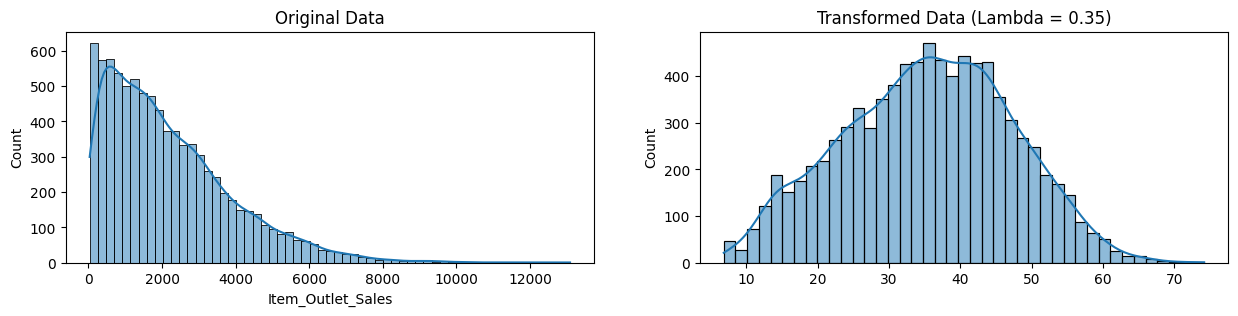

In [5]:
## Univirate analysis

normalized_data , lambda_value =stats.boxcox(train_Data["Item_Outlet_Sales"])
fig, axs = plt.subplots(1, 2, figsize=(15,3))

sns.histplot(train_Data["Item_Outlet_Sales"],ax=axs[0],kde=True, legend=False)
axs[0].set_title("Original Data")

sns.histplot(normalized_data, ax=axs[1], kde=True, legend=False)
axs[1].set_title("Transformed Data (Lambda = {})".format(round(lambda_value, 2)))
plt.show()

The kind of location and outlet size have a big influence on product sales. The performance of the regression models may thus be enhanced by integrating these characteristics.

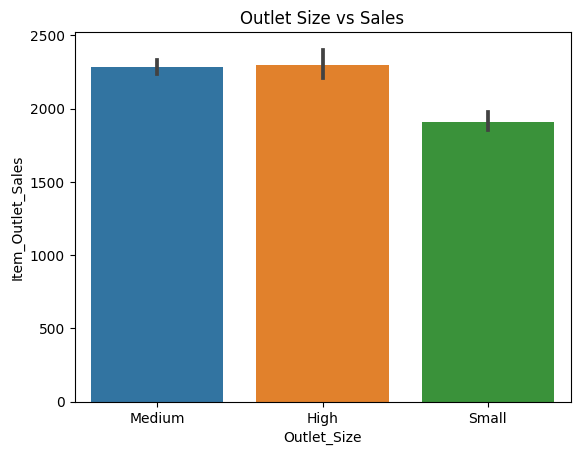

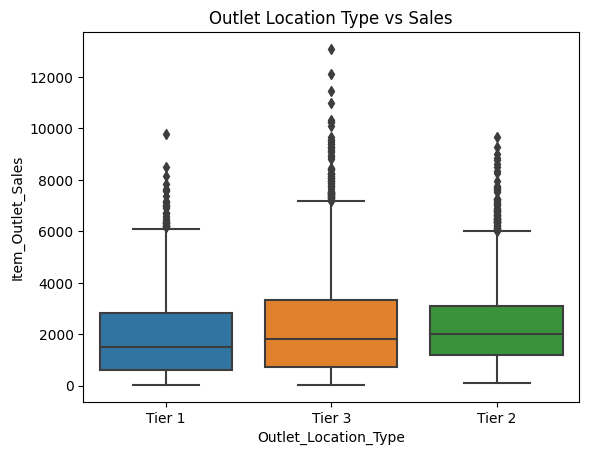

In [6]:
## Bivariant analysis
sns.barplot(x="Outlet_Size", y="Item_Outlet_Sales", data=train_Data)
plt.title("Outlet Size vs Sales")
plt.show()

sns.boxplot(x="Outlet_Location_Type", y="Item_Outlet_Sales", data=train_Data)
plt.title("Outlet Location Type vs Sales")
plt.show()

To improve the effectiveness of the models, the LabelEncoder was used instead of one-hot encoding. It was discovered that the LabelEncoder performed better than one-hot encoding in encoding categorical characteristics.

In [7]:
## label encoder
le = LabelEncoder()
train_Data= train_Data.apply(le.fit_transform)

## label encoder on test
le = LabelEncoder()
test_Data= test_Data.apply(le.fit_transform)


In [8]:
## Feature engineering cont.

test_Data = test_Data.drop(["Item_Identifier"], axis=1)
Y = train_Data["Item_Outlet_Sales"]
X = train_Data.drop(["Item_Outlet_Sales","Item_Identifier"], axis=1)

In [9]:
### Linear Regression Model

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=50)
Linear_Reg = LinearRegression()
Linear_Reg.fit(X_train, Y_train)

y_pred = Linear_Reg.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
print("Mean Square Error:", mse)
print("R-squared (R2) score:", r2)
print("Mean Absolute Error:", mae)

y_pred = Linear_Reg.predict(test_Data)



Mean Square Error: 365689.386129804
R-squared (R2) score: 0.5612136066703755
Mean Absolute Error: 486.8020601448425


In [10]:
### Ridge Regression Model

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=50)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)


y_pred = ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)

print("Mean Square Error::", mse)
print("R-squared (R2) score:", r2)
print("Mean Absolute Error:", mae)
y_pred = ridge.predict(test_Data)


Mean Square Error:: 365684.61595083616
R-squared (R2) score: 0.561219330352014
Mean Absolute Error: 486.800020711801


In [11]:
### Random Forest Model

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


rand_forest = RandomForestRegressor(n_estimators=100, random_state=42)
rand_forest.fit(X_train, y_train)

y_pred = rand_forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Square Error:", mse)
print("R-squared (R2) score:", r2)
print("Mean Absolute Error:", mae)
y_pred = rand_forest.predict(test_Data)

Mean Square Error: 295288.43517958943
R-squared (R2) score: 0.6411678763233883
Mean Absolute Error: 412.2258416422288


In [12]:
### XGboost Model
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}


model = xgb.train(params, dtrain, num_boost_round=100)
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Square Error::", mse)
print("R-squared (R2) score:", r2)
print("Mean Absolute Error:", mae)

Mean Square Error:: 269440.09130060265
R-squared (R2) score: 0.6725785752286101
Mean Absolute Error: 396.72795981018425


In [13]:
# Load the data and split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 500, 1000]
}


xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_grid = GridSearchCV(xgb_model, param_grid=xgb_params, cv=5)
xgb_grid.fit(X_train, y_train)
xgb_best_params = xgb_grid.best_params_

print("Best parameters for XGBoost:", xgb_best_params)

KeyboardInterrupt: ignored

In [ ]:
## Save Model
joblib.dump(xgb_grid,'D:\Bigmart predtion analysis\XGBoost_grid.sav')
Model=joblib.load('D:\Bigmart predtion analysis\XGBoost_grid.sav')